In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn.functional as F

from collections import OrderedDict
from torch.autograd import Variable
from IPython.core.display import display, HTML

In [2]:
df = pd.read_csv("../usda/usda.csv")
df.sample(3)

,name,group,protein (g),calcium (g),sodium (g),fiber (g),vitaminc (g),potassium (g),carbohydrate (g),sugars (g),fat (g),water (g),calories,saturated (g),monounsat (g),polyunsat (g),id
1861,"OSCAR MAYER, Pickle Pimiento Loaf (with chicken)",Sausages and Luncheon Meats,9.60,0.110,1.275,0.0,0,0.174,9.10,6.9,21.60,55.80,269,6.990,10.430,2.810,29342
7187,"TACO BELL, Soft Taco with chicken",Fast Foods,14.33,0.105,0.606,1.8,0,0.237,19.58,0.0,7.32,56.42,202,2.614,2.832,1.055,34668
5457,"WORTHINGTON Smoked Turkey Roll, frozen, unprep...",Legumes and Legume Products,18.50,0.147,0.859,1.1,0,0.098,7.90,2.4,16.10,53.70,251,2.300,3.900,8.900,32938


In [3]:
# nutritional components we choose to work on
nutritional_components = [
 'protein (g)',
 'sodium (g)',
 'fiber (g)',
 'carbohydrate (g)',
 'sugars (g)',
 'fat (g)',
 'calories',
 'saturated (g)'
]
df = df[nutritional_components].copy()

In [4]:
# nutritional composotion of different food
food_composition = {
    "sugar": df.iloc[6621],
    "lactose": df.iloc[6621],
    "dextrose/sugar": df.iloc[6621],
    "cocoa_butter": df.iloc[701],
    "palm_oil": df.iloc[740],
    "emulsifier": df.iloc[748],
    "hazelnut": df.iloc[3885],
    "roasted_peanuts": df.iloc[5318],
    "cocoa": df.iloc[6451],
    "low_fat_cocoa": df.iloc[6452],
    "nonfat_milk_powder": df.iloc[177],
    "salt": df.iloc[247],
    "milk_fat": pd.Series(OrderedDict([("protein (g)", 6.3), ("sodium (g)", 0.107), ("fiber (g)", 3.), ("carbohydrate (g)", 57.5), ("sugars (g)", 56.3), ("fat (g)", 30.9), ("calories", 539), ("saturated (g)", 10.6), ])),
    "nutella": pd.Series(OrderedDict([("protein (g)", 6.3), ("sodium (g)", 0.107), ("fiber (g)", 3.), ("carbohydrate (g)", 57.5), ("sugars (g)", 56.3), ("fat (g)", 30.9), ("calories", 539), ("saturated (g)", 10.6), ])), # 
    "peanut_butter_cups": pd.Series(OrderedDict([("protein (g)", 9.5), ("sodium (g)", 0.3), ("fiber (g)", 2.4), ("carbohydrate (g)", 54.8), ("sugars (g)", 47.6), ("fat (g)", 31.0), ("calories", 547.6), ("saturated (g)", 10.7)]))
}

In [5]:
# Reese's Peanut Butter Cups
ingredients = ["sugar", "cocoa_butter", "cocoa", "nonfat_milk_powder", "milk_fat", "lactose", "emulsifier", "roasted_peanuts", "dextrose/sugar", "salt"]
ingredient_weights = [None]*len(ingredients)
target = "peanut_butter_cups"

In [6]:
ig_weights = OrderedDict(zip(ingredients, ingredient_weights))
print("%s ingredients:" % target, json.dumps(ig_weights, indent=2))

peanut_butter_cups ingredients: {
  "sugar": null,
  "cocoa_butter": null,
  "cocoa": null,
  "nonfat_milk_powder": null,
  "milk_fat": null,
  "lactose": null,
  "emulsifier": null,
  "roasted_peanuts": null,
  "dextrose/sugar": null,
  "salt": null
}


In [7]:
# Formulate the problem as an optimization task:
# - linear model without bias
# - one training sample per nutritional component (proteins, carbs, etc.)
# - each sample Xi from X is a row vector containing the percentage of a given nutritional component in each ingredient
# - each output Yi from Y is a scalar corresponding to the total amount of this nutrinional component in the final product
# - after training, the weights are the amount of unknown ingredients in grams

X = torch.zeros(len(nutritional_components), len(ingredients))
W = torch.zeros(len(ingredients), 1)
Y = torch.zeros(len(nutritional_components), 1)

for i, nutritional_component in enumerate(nutritional_components):
    for j, ingredient in enumerate(ingredients):
        X[i,j] = float(food_composition[ingredient][nutritional_component])
    Y[i,0] = food_composition[target][nutritional_component]

# initializing weights with what we know
for i, ingredient in enumerate(ingredients):
    if ingredient_weights[i] is not None:
        W[i,0] = ingredient_weights[i]

print("X=", X)
print("W=", W)
print("Y=", Y)

# normalization to be more efficient on smaller nutritional amounts
Y_scaler = Y.clone()
X.div_(Y_scaler)
_ = Y.div_(Y_scaler)

X= 

Columns 0 to 7 
   0.0000    0.0000   16.8000   36.1600    6.3000    0.0000    0.0000   23.6800
   0.0010    0.0000    0.0200    0.5350    0.1070    0.0010    0.0000    0.0060
   0.0000    0.0000   33.9000    0.0000    3.0000    0.0000    0.0000    8.0000
  99.9800    0.0000   49.7100   51.9800   57.5000   99.9800    0.0000   21.5100
  99.8000    0.0000    1.5300   51.9800   56.3000   99.8000    0.0000    4.1800
   0.0000  100.0000   23.7100    0.7700   30.9000    0.0000  100.0000   49.6600
 387.0000  884.0000  479.0000  362.0000  539.0000  387.0000  763.0000  585.0000
   0.0000   59.7000   12.6400    0.4990   10.6000    0.0000   15.0050    6.8930

Columns 8 to 9 
   0.0000    0.0000
   0.0010   38.7580
   0.0000    0.0000
  99.9800    0.0000
  99.8000    0.0000
   0.0000    0.0000
 387.0000    0.0000
   0.0000    0.0000
[torch.FloatTensor of size 8x10]

W= 
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 10x1]

Y= 
   9.5000
   0.3000
   2.4

In [8]:
X = Variable(X, requires_grad=False)
W = Variable(W, requires_grad=True)
Y = Variable(Y, requires_grad=False)

In [9]:
epochs = 5000
loss_history = np.zeros((epochs))
for epoch in range(epochs):
    Y_pred = X.mm(W)
    
    # l2 loss
    loss = (Y_pred - Y).pow(2).sum()
    
    # try to go and stay at 100g total
    loss += (W.sum()-1.).abs()*5
    
    loss_history[epoch] = loss.data[0]
    loss.backward()

    for i in range(W.size(0)):
        if ingredient_weights[i] is None: # update only unknown quantities
            W.data[i].sub_(1e-5 * W.grad[i].data)
            
            
            if ingredients[i] == "emulsifier": # common sense (max 0.5% of emulsifier)
                W.data[i].clamp_(0., 0.005 * (1 if not target=="peanut_butter_cups" else W[:7,:].sum().data[0]))
            
            # keep mass positives
            W.data[i].clamp_(0., 100.)
            
            # keep ingredients in order
            upper_lim = 100. if i==0 else W.data[i-1,0]
            lower_lim = 0. if (i+1)==len(W) else W.data[i+1,0]
            
            if target == "peanut_butter_cups":
                if i<=6: # milk chocolate "nested" ingredients
                    upper_lim = 100. if i==0 else W.data[i-1,0]
                    lower_lim = 0. if (i+1)==7 else W.data[i+1,0]
                    
                else: # peanut butter filling
                    upper_lim = 100. if i==7 else W.data[i-1,0]
                    lower_lim = 0. if (i+1)==len(W) else W.data[i+1,0]
            
            W.data[i].clamp_(lower_lim, upper_lim)
            
    W.grad.data.zero_()

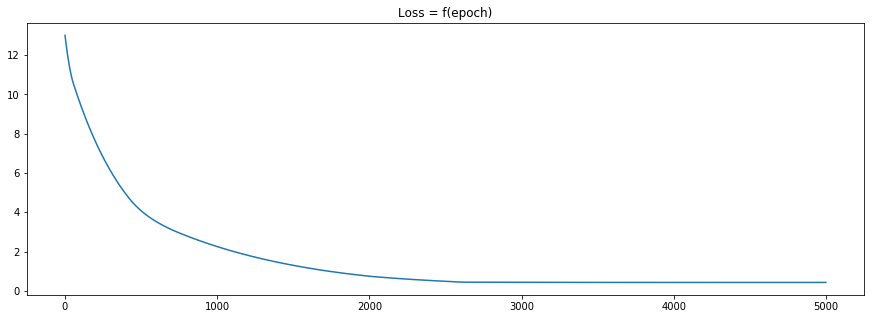

estimated composition for peanut_butter_cups = {
  "sugar": "20.3g",
  "cocoa_butter": "16.0g",
  "cocoa": "6.3g",
  "nonfat_milk_powder": "6.3g",
  "milk_fat": "6.3g",
  "lactose": "6.3g",
  "emulsifier": "0.3g",
  "roasted_peanuts": "18.7g",
  "dextrose/sugar": "18.7g",
  "salt": "0.7g"
}
total: 100.0g
milk chocolate: 62.0%
peanut butter filling: 38.0%
final loss: 0.4


,truth,prediction,l1 error,l2 error
protein (g),9.500000,8.172929,1.327071,1.761118
sodium (g),0.300000,0.302817,-0.002817,0.000008
fiber (g),2.400000,3.829271,-1.429271,2.042815
carbohydrate (g),54.799999,59.433804,-4.633804,21.472143
sugars (g),47.599998,52.990505,-5.390507,29.057564
fat (g),31.000000,29.112617,1.887383,3.562213
calories,547.599976,516.109497,31.490479,991.650208
saturated (g),10.700000,12.401729,-1.701729,2.895881


In [10]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.set_title("Loss = f(epoch)")
ax.plot(loss_history)
ax.legend()
plt.show()

weights = OrderedDict([(ingredients[i], "%.1fg" % (W.data[i,0]*100)) for i in range(len(ingredients))])
print("estimated composition for %s =" % target, json.dumps(weights, indent=2))
print("total: %.1fg" % np.sum([W.data[i,0]*100 for i in range(len(ingredients))]))

if target == "peanut_butter_cups":
    print("milk chocolate: %.1f%%" % np.sum([W.data[i,0]*100 for i in range(7)]))
    print("peanut butter filling: %.1f%%" % np.sum([W.data[i+7,0]*100 for i in range(3)]))

print("final loss: %.1f" % loss.data[0])

s1 = pd.Series(Y.data.numpy().reshape(-1), index=nutritional_components, name='truth')
s2 = pd.Series(X.mm(W).data.numpy().reshape(-1), index=nutritional_components, name='prediction')
s1 *= Y_scaler.numpy().reshape(-1)
s2 *= Y_scaler.numpy().reshape(-1)
s3 = pd.Series(s1 - s2, index=nutritional_components, name='l1 error')
s4 = pd.Series(np.power(s1 - s2, 2), index=nutritional_components, name='l2 error')
df = pd.concat([s1, s2, s3, s4], axis=1)
display(HTML(df.to_html()))